<a href="https://colab.research.google.com/github/moo-mu/GAN1/blob/mid/dilation_layer%2C_reduced_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#google drive 마운트 후에 수집한 이미지 파일 unzip
%cd /content/drive/MyDrive
#!unzip -qq "/content/drive/MyDrive/apple2banana.zip" #apple2banana 케이스
!unzip -qq "/content/drive/MyDrive/animals.zip" #cat2dog 케이스

/content/drive/MyDrive
replace animals/testA/flickr_cat_000008.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#내가 설정한 경로가 맞나? 확인용.
import pathlib
#p_file = pathlib.Path('/content/drive/MyDrive/apple2banana/trainA/Screen Shot 2018-06-08 at 4.59.36 PM.png')
p_file = pathlib.Path('/content/drive/MyDrive/animals/trainA/flickr_cat_000002.jpg')
print(p_file.is_file())

p_dir = pathlib.Path('/content/drive/MyDrive/animals/trainB')
print(p_dir.is_dir())

True
True


In [ ]:
import scipy
import imageio
from skimage.transform import resize
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('/content/drive/MyDrive/%s/%s/*' % (self.dataset_name, data_type))
        

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('/content/drive/MyDrive/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('/content/drive/MyDrive/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(float)
    
#print(glob('/content/drive/MyDrive/apple2orange/trainA/*'))
#print(len('/content/drive/MyDrive/apple2orange/trainA/*'))

#구글 드라이브에 파일이 빠짐없이 압축해제 되었는지 보려고 써봄. 개수가 잘 맞음.
#countForFileNum = 0
#for path in p_dir.iterdir():
#    if path.is_file():
#        countForFileNum += 1

#print(countForFileNum)   

In [ ]:
!pip install tensorflow-addons==0.10
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)


        self.dataset_name = 'apple2banana'
        #self.dataset_name = 'animals'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))
        
        ##patch = int(self.img_rows / 2**4)
        patch = int(self.img_rows / 2**6) 
        self.disc_patch = (patch, patch, 1)

        self.gf = 32
        self.df = 64

        #self.lambda_cycle = 10.0      
        #self.lambda_id = 0.9 * self.lambda_cycle    
        self.lambda_cycle = 2.0       
        self.lambda_id = 0.9 * self.lambda_cycle    
        #self.lambda_cycle = 0                   # cycle-consistency loss, identity loss 무시 
        #self.lambda_id = 0 #0.9 * self.lambda_cycle

        optimizer = Adam(0.0002, 0.5)
        
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)

        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        self.d_A.trainable = False
        self.d_B.trainable = False

        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
class CycleGAN(CycleGAN):
      @staticmethod
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            #print(u.shape)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

In [ ]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        d0 = Input(shape=self.img_shape)#(None, 128, 128, 3)
        #print(d0.shape)

        d1 = self.conv2d(d0, self.gf) #(None, 64, 64, 32)
        #print(d1.shape)
        d2 = self.conv2d(d1, self.gf * 2) #(None, 32, 32, 64)
        #print(d2.shape)
        d3 = self.conv2d(d2, self.gf * 4) #(None, 16, 16, 128)
        #print(d3.shape)
        d4 = self.conv2d(d3, self.gf * 8) #(None, 8, 8, 256)
        #print(d4.shape)

        #d4 = Conv2D(self.gf * 8, kernel_size=4, strides=1, padding='same')(d3)
        #d4 = LeakyReLU(alpha=0.2)(d4)
        #d4 = InstanceNormalization()(d4) # 16x16x256
        

        u1 = self.deconv2d(d4, d3, self.gf * 4) #(None, 16, 16, 256)
        #print("u1shape:",u1.shape)
        u2 = self.deconv2d(u1, d2, self.gf * 2) #(None, 32, 32, 128)
        #print(u2.shape)
        u3 = self.deconv2d(u2, d1, self.gf) #(None, 64, 64, 64)
        #print(u3.shape)

        u4 = UpSampling2D(size=2)(u3) #(None, 128, 128, 64)
        #print(u4.shape)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)
        print(output_img.shape)

        return Model(d0, output_img)

In [ ]:
##dilated convoluttion 적용. dropout rate, kernel_size, validity 부분 점검
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      img = Input(shape=self.img_shape) #(128,128)

      d1 = self.conv2d(img, self.df*2, normalization=False) #(64,64,128)
      print("d1shape: ",d1.shape)
      d2 = self.conv2d(d1, self.df * 4) #(32,32,256)
      print("d2shape: ",d2.shape)
      d3 = self.conv2d(d2, self.df * 8) #(16,16,512)
      print("d3shape: ",d3.shape)
      d4 = self.conv2d(d3, self.df * 8) #(8,8,512)
      print("d4shape: ",d4.shape)

      dil1 = Conv2D(self.df * 8, kernel_size=4, strides=1, padding='same', dilation_rate=2)(d4)
      dil1 = LeakyReLU(alpha=0.2)(dil1)
      dil1 = InstanceNormalization()(dil1)

      dil2 = Conv2D(self.df * 8, kernel_size=4, strides=1, padding='same', dilation_rate=4)(dil1)
      dil2 = LeakyReLU(alpha=0.2)(dil2)
      dil2 = InstanceNormalization()(dil2)

      dil3 = Conv2D(self.df * 8, kernel_size=4, strides=1, padding='same', dilation_rate=8)(dil2)
      dil3 = LeakyReLU(alpha=0.2)(dil3)
      dil3 = InstanceNormalization()(dil3)
      
      merge = Concatenate()([dil3, d4])
      
      d5 = Conv2D(self.df * 8, kernel_size=4, strides=2, padding='same')(merge)
      d5 = LeakyReLU(alpha=0.2)(d5)
      d5 = InstanceNormalization()(d5)

      validity = Conv2D(1, kernel_size=4, strides=2, padding='same')(d5)
      print("validityshape: ",validity.shape)

      return Model(img, validity)

In [ ]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)

        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig('/content/drive/MyDrive/images2/%s/%d_%d.png' % (self.dataset_name, epoch, batch_i))
        plt.show()

In [ ]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])

                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

d1shape:  (None, 64, 64, 128)
d2shape:  (None, 32, 32, 256)
d3shape:  (None, 16, 16, 512)
d4shape:  (None, 8, 8, 512)
validityshape:  (None, 2, 2, 1)
d1shape:  (None, 64, 64, 128)
d2shape:  (None, 32, 32, 256)
d3shape:  (None, 16, 16, 512)
d4shape:  (None, 8, 8, 512)
validityshape:  (None, 2, 2, 1)
u1shape: (None, 16, 16, 256)
(None, 128, 128, 3)
u1shape: (None, 16, 16, 256)
(None, 128, 128, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


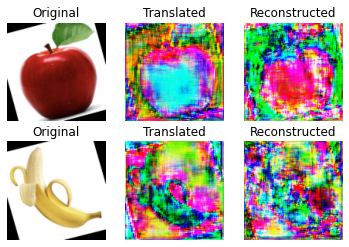

In [ ]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)